# Cost Function for Model Parameter Fitting

In [20]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import random
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
hppc_DIR = "../data/hppc/"
crate_DIR = "../data/crate/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_model/"
res_DIR = "../data/results/"

# %matplotlib widget

In [2]:
spm = pybamm.lithium_ion.SPMe(
    {
        # "SEI": "ec reaction limited",
        # # "loss of active material": ("stress-driven","none"),
        # "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [3]:
parameter_values = get_parameter_values()

In [4]:
cell = 4
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")

In [5]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        # "Positive electrode LAM constant proportional term [s-1]": 1.2676e-07,#2.7081e-07, #4.1759e-07,#2.7081e-07, #2.5112e-07,
        # "Negative electrode LAM constant proportional term [s-1]": 1.2713e-06,#3.7576e-06, #3.2693e-06,#3.7576e-06, #2.4741e-06,
        # "Positive electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        # "Negative electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        # "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        # "EC diffusivity [m2.s-1]": 8.30909086e-19,
        # "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": 4.244E-6,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)

In [24]:
def model_error(data_time,data_current,data_voltage,parameter_values,SOC_0=0,plot_bool=False):
    # t_int = np.arange(0,data_time[-1],1)
    t_int = data_time
    f_I_int = interpolate.interp1d(data_time,-data_current)
    f_V_int = interpolate.interp1d(data_time,data_voltage)

    I_int = f_I_int(t_int)
    V_int = f_V_int(t_int)
    timescale = parameter_values.evaluate(spm.timescale)
    current_interpolant = pybamm.Interpolant(
    #  drive_cycle[:, 0], drive_cycle[:, 1], timescale * pybamm.t
    t_int, I_int, timescale * pybamm.t
    )

    pybamm.set_logging_level("NOTICE")
    parameter_values["Current function [A]"] = current_interpolant
    # var_pts=var_pts,
    sim = pybamm.Simulation(spm, 
                            parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver(
                                mode="safe", 
                                rtol=1e-6, 
                                atol=1e-6,
                                dt_max=10,
                                )
                            )
    # sim.solve(initial_soc = SOC_0)
    sim.solve(t_eval=t_int,initial_soc = SOC_0)
    solution = sim.solution
    t = solution["Time [s]"].entries
    V_sim = solution["Terminal voltage [V]"].entries
    I_sim = solution["Current [A]"].entries
    # Q = -solution['Discharge capacity [A.h]'].entries
    # f_I_sim = interpolate.interp1d(t,I,bounds_error=False,fill_value="extrapolate")
    # f_V_sim = interpolate.interp1d(t,V,bounds_error=False,fill_value="extrapolate")
    # I_sim = f_I_sim(t_int)
    # V_sim = f_V_sim(t_int)
    I_int = f_I_int(t)
    V_int = f_V_int(t)
    rmse = pybamm.rmse(V_int,V_sim)
    if plot_bool:
        print("plot")
        fig, ax1 = plt.subplots(1, 1, figsize=(5, 4), sharex=True)
        ax1.plot(t, V_int, 'k')
        ax1.plot(t, V_sim, 'b--')
        ax1.text(0.7,0.2,f'RMSE: {rmse*1e3:0.1f} mV',transform=ax1.transAxes)
        # ax1.plot(t1, V1, 'r-.')
        ax1.set_ylabel("Voltage [V]")
        # ax1.set_title("Cell 01 Fresh HPPC")
        ax1.set_ylim([3,4.2])
        ax1.set_xlabel("Time [s]")
        # ax1.set_xlim([20370,20470])
        ax1.legend(['data','sim'])
        fig.tight_layout()
        plt.show()
        fig.savefig(fig_DIR+str(int(10000*random.random()))+".png")
    return rmse

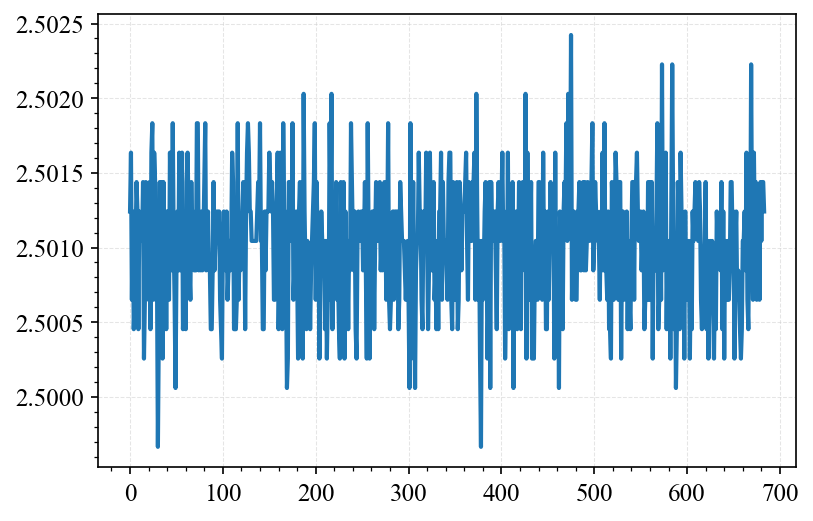

In [31]:
plt.plot(I_d1_c2)

In [7]:
crate_data_raw = pd.read_csv(crate_DIR+'crate_data_cell_'+cell_no+'.csv')
crate_data_raw = crate_data_raw[ crate_data_raw['Cycle number'] == 0 ]
crate_data = crate_data_raw
t_d1 = crate_data['Time [s]']-crate_data['Time [s]'][0]
t_d1 = t_d1.values
I_d1 = crate_data['Current [mA]']/1000
I_d1 = I_d1.values
V_d1 = crate_data['Voltage [V]']
V_d1 = V_d1.values
idx_I = np.where(np.sign(I_d1[:-1]) != np.sign(I_d1[1:]))[0] + 1
idx_I = idx_I[idx_I>50]
# C/10
nn = 0
t_d1_c10 = t_d1[idx_I[nn+0]:idx_I[nn+1]]-t_d1[idx_I[nn+0]]
I_d1_c10 = I_d1[idx_I[nn+0]:idx_I[nn+1]]
V_d1_c10 = V_d1[idx_I[nn+0]:idx_I[nn+1]]
# C/5
nn = 4
t_d1_c5 = t_d1[idx_I[nn+0]:idx_I[nn+1]]-t_d1[idx_I[nn+0]]
I_d1_c5 = I_d1[idx_I[nn+0]:idx_I[nn+1]]
V_d1_c5 = V_d1[idx_I[nn+0]:idx_I[nn+1]]
# C/2
nn = 8
t_d1_c2 = t_d1[idx_I[nn+0]:idx_I[nn+1]]-t_d1[idx_I[nn+0]]
I_d1_c2 = I_d1[idx_I[nn+0]:idx_I[nn+1]]
V_d1_c2 = V_d1[idx_I[nn+0]:idx_I[nn+1]]
# 1C
nn = 12
t_d1_c1 = t_d1[idx_I[nn+0]:idx_I[nn+1]]-t_d1[idx_I[nn+0]]
I_d1_c1 = I_d1[idx_I[nn+0]:idx_I[nn+1]]
V_d1_c1 = V_d1[idx_I[nn+0]:idx_I[nn+1]]
# HPPC
hppc_data_raw = pd.read_csv(hppc_DIR+'hppc_data_cell_'+cell_no+'.csv')
hppc_data_raw = hppc_data_raw[ hppc_data_raw['Cycle number'] == 0 ]
idx_hppc = hppc_data_raw['Current [mA]'].lt(0).idxmax()
hppc_data = hppc_data_raw.iloc[idx_hppc:,:]
hppc_data = hppc_data.reset_index(drop=True)
t_d1_hppc = hppc_data['Time [s]']-hppc_data['Time [s]'][0]
t_d1_hppc= t_d1_hppc.values
I_d1_hppc = hppc_data['Current [mA]']/1000
I_d1_hppc = I_d1_hppc.values
V_d1_hppc= hppc_data['Voltage [V]']
V_d1_hppc = V_d1_hppc.values

In [ ]:
# print("RMSE")
# rmse = model_error(t_d1_c10,I_d1_c10,V_d1_c10,parameter_values,SOC_0=0)
# print(f"C/10: {rmse}")
# rmse = model_error(t_d1_c5,I_d1_c5,V_d1_c5,parameter_values,SOC_0=0)
# print(f"C/5: {rmse}")
# rmse = model_error(t_d1_c2,I_d1_c2,V_d1_c2,parameter_values,SOC_0=0)
# print(f"C/2: {rmse}")
# rmse = model_error(t_d1_c1,I_d1_c1,V_d1_c1,parameter_values,SOC_0=0)
# print(f"1C: {rmse}")
# rmse = model_error(t_d1_hppc,I_d1_hppc,V_d1_hppc,parameter_values,SOC_0=1,plot_bool=False)
# print(f"HPPC: {rmse}")

In [ ]:
# rmse = model_error(t_d1_c10,I_d1_c10,V_d1_c10,parameter_values,SOC_0=0,plot_bool=True)
# rmse = model_error(t_d1_c5,I_d1_c5,V_d1_c5,parameter_values,SOC_0=0,plot_bool=True)
# rmse = model_error(t_d1_c2,I_d1_c2,V_d1_c2,parameter_values,SOC_0=0,plot_bool=True)
# rmse = model_error(t_d1_c1,I_d1_c1,V_d1_c1,parameter_values,SOC_0=0,plot_bool=True)
# rmse = model_error(t_d1_hppc,I_d1_hppc,V_d1_hppc,parameter_values,SOC_0=1,plot_bool=True)

In [ ]:
parameter_values.search('diffus')

In [ ]:
x = np.array([1.0,1.0,1.0,1.0])
parameter_values.update(
    {
        "Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": x[0]*4.244E-6,
        "Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]":	x[1]*4.824e-06,
        "Negative electrode diffusion coefficient [m2.s-1]": x[2]*8e-14,
        "Positive electrode diffusion coefficient [m2.s-1]": x[3]*8e-15,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)
rmse1 = model_error(t_d1_c10,I_d1_c10,V_d1_c10,parameter_values,SOC_0=0,plot_bool=True)

In [ ]:
def prediction_error(x):
    try:
        parameter_values.update(
            {
                "Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": x[0]*4.244E-6,
                "Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]":	x[1]*4.824e-06,
                "Negative electrode diffusion coefficient [m2.s-1]": x[2]*8e-14,
                "Positive electrode diffusion coefficient [m2.s-1]": x[3]*8e-15,
                # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
                # "EC diffusivity [m2.s-1]": 2e-18,
                # "SEI growth activation energy [J.mol-1]": 0,
            },
            check_already_exists=False,
        )
        rmse1 = model_error(t_d1_c10,I_d1_c10,V_d1_c10,parameter_values,SOC_0=0,plot_bool=False)
        rmse2 = model_error(t_d1_c5,I_d1_c5,V_d1_c5,parameter_values,SOC_0=0,plot_bool=False)
        rmse3 = model_error(t_d1_c2,I_d1_c2,V_d1_c2,parameter_values,SOC_0=0,plot_bool=False)
        rmse4 = model_error(t_d1_c1,I_d1_c1,V_d1_c1,parameter_values,SOC_0=0,plot_bool=False)
        # rmse5 = model_error(t_d1_hppc,I_d1_hppc,V_d1_hppc,parameter_values,SOC_0=1,plot_bool=False)
        out = rmse1 + rmse2 + rmse3 + rmse4 #+ rmse5
        out = np.array([out])
        # out = rmse1 
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    except:
        out = 5
        out = np.array([out])
        print(f"x={x}, norm={np.linalg.norm(out)}")
        return out
    return out
def train_model():
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0,1.0,1.0])
    # print(prediction_error(x0))
    soln_dfols = dfols.solve(prediction_error, x0, rhoend=1e-3)
    print(timer.time())
    return soln_dfols

In [ ]:
soln_dfols = train_model()
xsol = soln_dfols.x

In [25]:
def plot_fit(x,plot_bool = True):
    parameter_values.update(
        {
            "Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": x[0]*1*4.244E-6,
            "Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]":	x[1]*4.824e-06,
            "Negative electrode diffusion coefficient [m2.s-1]": x[2]*8e-14,
            "Positive electrode diffusion coefficient [m2.s-1]": x[3]*8e-15,
            # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
            # "EC diffusivity [m2.s-1]": 2e-18,
            # "SEI growth activation energy [J.mol-1]": 0,
        },
        check_already_exists=False,
    )
    print("RMSE")
    rmse = model_error(t_d1_c10,I_d1_c10,V_d1_c10,parameter_values,SOC_0=0,plot_bool=plot_bool)
    print(f"C/10: {rmse}")
    rmse = model_error(t_d1_c5,I_d1_c5,V_d1_c5,parameter_values,SOC_0=0,plot_bool=plot_bool)
    print(f"C/5: {rmse}")
    rmse = model_error(t_d1_c2,I_d1_c2,V_d1_c2,parameter_values,SOC_0=0,plot_bool=plot_bool)
    print(f"C/2: {rmse}")
    rmse = model_error(t_d1_c1,I_d1_c1,V_d1_c1,parameter_values,SOC_0=0,plot_bool=plot_bool)
    print(f"1C: {rmse}")
    # rmse = model_error(t_d1_hppc,I_d1_hppc,V_d1_hppc,parameter_values,SOC_0=1,plot_bool=plot_bool)
    # print(f"HPPC: {rmse}")
    # out = rmse1 

"Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": x[0]*4.244E-6,
"Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]":	x[1]*4.824e-06,
"Negative electrode diffusion coefficient [m2.s-1]": x[2]*8e-14,
"Positive electrode diffusion coefficient [m2.s-1]": x[3]*8e-15,

x=[0.75623191 1.02509399 4.04314049 4.58122543], norm=0.04686509511903915

"Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": x[0]/10*4.244E-6,
x=[ 6.88621322  2.70386313  5.10244654 18.32567884], norm=0.045663133892884684

In [ ]:
print(0.75623191/1*4.244E-6)
print(6.88621322/10*4.244E-6)

In [27]:
xsol = [0.75623191, 1.02509399, 4.04314049, 4.58122543]
xsol = [1, 1 ,1 ,1]

RMSE
plot


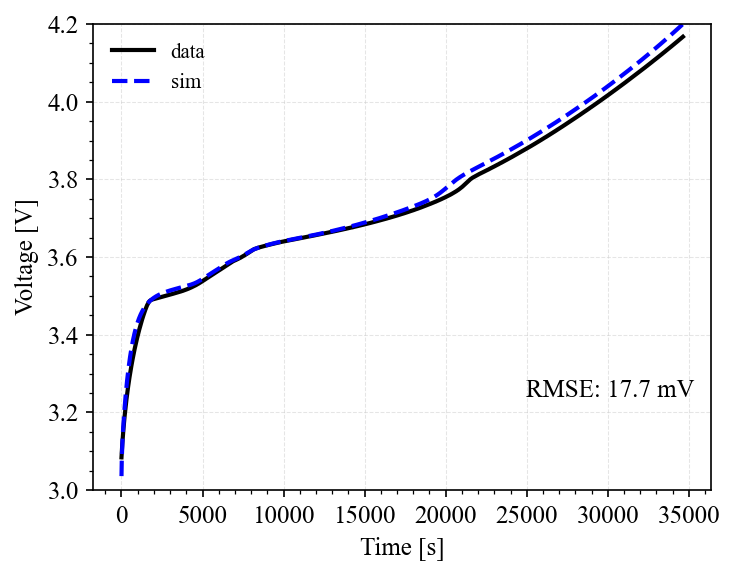

C/10: 0.01765736194193891
plot


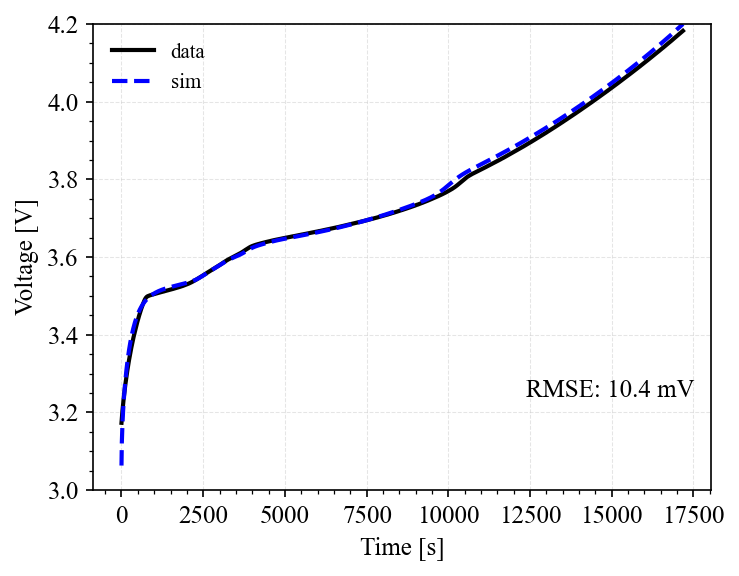

C/5: 0.010414841583629049
plot


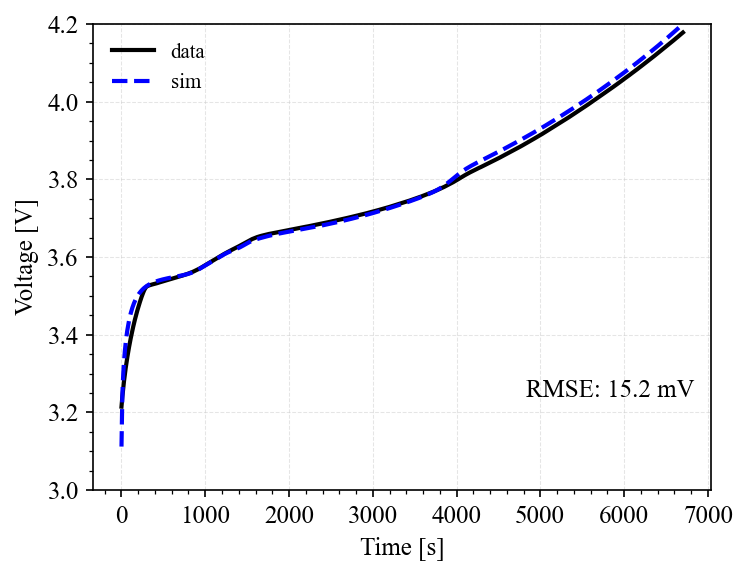

C/2: 0.015242984698756432
plot


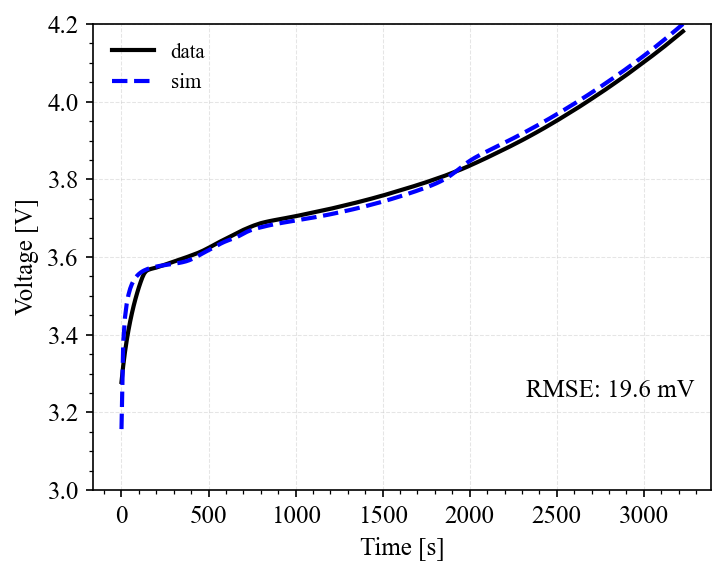

1C: 0.019582005104715798


In [28]:
plot_fit(xsol,plot_bool = True)